### Problema 1 Un Query en SQL

Tenemos la siguiente _query_:
```SQL
SELECT gaia.source_id, gaia.hip,
    gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 AS g_mag_abs_gaia,
    gaia.phot_g_mean_mag+5*log10(hip.plx)-10 AS g_mag_abs_hip,
    hip."B-V"
FROM "I/337/tgas" AS gaia
INNER JOIN "I/311/hip2" AS hip
ON gaia.hip = hip.HIP
WHERE gaia.parallax/gaia.parallax_error >= 5 AND
    hip.Plx/hip.e_Plx >= 5 AND
    hip."e_B-V" > 0.0 AND hip."e_B-V" <= 0.05 AND
    (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05
```

La _query_ anterior hace un match entre las columnas que tienen los identificadores de Hipparcos de las tablas de la base de datos de TGAS e Hipparcos 2. Los datos que se están seleccionando deben cumplir las siguientes condiciones:
1. Tener una señal al ruido en el paralaje mayor o igual a 5.
2. Un error en el índice de color B-V  entre 0 y 0.05.
3. Un [error](http://www.astro.rug.nl/~belikov/VO2012/Lectures/Lecture5.pdf "Ver diapositiva 23 para la definición del error en la magnitud") en la magnitud menor o igual a 0.05

Los datos seleccionados corresponden a:
1. La ID de la estrella en Gaia.
2. La ID de la estrella en Hipparcos.
3. La magnitud absoluta G utilizando el paralaje de GAIA.
4. La magnitud absoluta G utilizando el paralaje de Hipparcos.
5. El índice color B-V de Hipparcos 2.

Ahora utilizamos esta _query_:

In [1]:
import act4
%matplotlib inline

tap_endpoint = "http://tapvizier.u-strasbg.fr/TAPVizieR/tap"
adql_query = '''
SELECT gaia.source_id, gaia.hip,
    gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 AS g_mag_abs_gaia,
    gaia.phot_g_mean_mag+5*log10(hip.plx)-10 AS g_mag_abs_hip,
    hip."B-V"
FROM "I/337/tgas" AS gaia
INNER JOIN "I/311/hip2" AS hip
ON gaia.hip = hip.HIP
WHERE gaia.parallax/gaia.parallax_error >= 5 AND
    hip.Plx/hip.e_Plx >= 5 AND
    hip."e_B-V" > 0.0 AND hip."e_B-V" <= 0.05 AND
    (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05
'''
tabla = act4.query_TAP(tap_endpoint, adql_query)


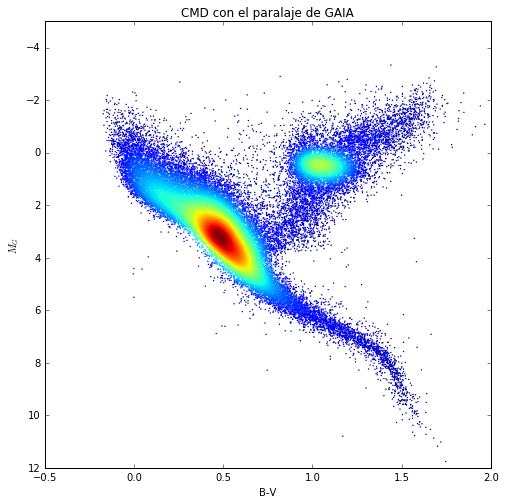

In [2]:
act4.plot_scatter_density(tabla, 'B-V', 'g_mag_abs_gaia', 'B-V',
                         '$M_G$', 'CMD con el paralaje de GAIA',
                          xlim=(-0.5, 2), ylim=(-5, 12))

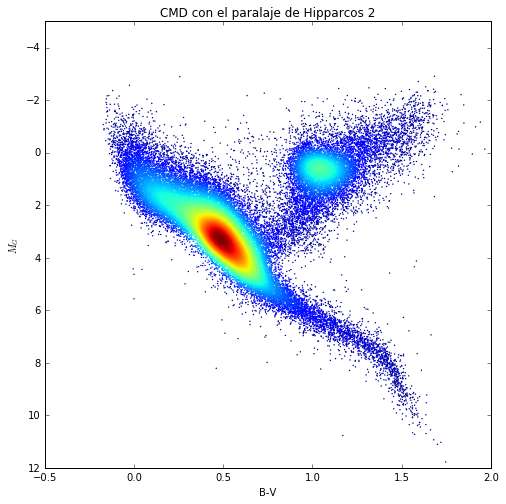

In [3]:
act4.plot_scatter_density(tabla, 'B-V', 'g_mag_abs_hip', 'B-V',
                         '$M_G$', 'CMD con el paralaje de Hipparcos 2',
                          xlim=(-0.5, 2), ylim=(-5, 12))

### Problema 2 Haciendo queries en SDSS

El Sloan Digital Sky Survey (SDSS) es un proyecto cuyo [objetivo](http://cas.sdss.org/dr13/en/sdss/data/data.aspx) es realizar un mapa 3D del cielo (tomando 1/4 de éste) con objetos con magnitud mayor a 23 en cinco filtros distintos (dsede el ultravioleta al infrarojo cercano). El [SDSS](http://cas.sdss.org/dr13/en/sdss/sdsshome.aspx) ha mapeado más de 100 millones de objetos, entre los cuales se encuentran estrellas, galaxias y quasars. Gracias a su [espectógrafo](http://cas.sdss.org/dr13/en/sdss/data/data.aspx), se ha podido determinar el redshift de estos objetos. Su importancia en la astronomía moderna radica en su basto catálogo de los objetos más extremos de nuestros universo, junto con ayudarnos a obtener una estructura a gran escala del universo.

El [DR8](http://adsabs.harvard.edu/abs/2011ApJS..193...29A) corresponde a los datos liberados para la tercera fase del SDSS, comenzada en el 2008 y publicada en el 2011. Esta [contiene](http://www.sdss3.org/dr8/scope.php) más de 400 millones de objetos para un área de 14 555 deg$^2$:

Tenemos la siguiente _query_ para el DR8:
```SQL
SELECT
    G.ra, G.dec, S.mjd, S.plate, S.fiberID,
    S.z, S.zErr, S.rChi2, S.velDisp, S.velDispErr,
    G.extinction_r, G.petroMag_r, G.psfMag_r, G.psfMagErr_r,
    G.modelMag_u, G.modelMagErr_u, G.modelMag_g, G.modelMagErr_g,
    G.modelMag_r, G.modelMagErr_r, G.modelMag_i, G.modelMagErr_i,
    G.modelMag_z, G.modelMagErr_z, G.petroR50_r, G.petroR90_r,
    GSL.nii_6584_flux, GSL.nii_6584_flux_err, GSL.h_alpha_flux,
    GSL.h_alpha_flux_err, GSL.oiii_5007_flux, GSL.oiii_5007_flux_err,
    GSL.h_beta_flux, GSL.h_beta_flux_err, GSL.h_delta_flux, GSL.h_delta_flux_err,
    GSX.d4000, GSX.d4000_err, GSE.bptclass,
    GSE.lgm_tot_p50, GSE.sfr_tot_p50, G.objID, GSI.specObjID
INTO mydb.SDSS FROM SpecObj S CROSS APPLY
    dbo.fGetNearestObjEQ(S.ra, S.dec, 0.06) N, Galaxy G,
    GalSpecInfo GSI, GalSpecLine GSL, GalSpecIndx GSX,
    GalSpecExtra GSE
WHERE N.objID = G.objID
    AND GSI.specObjID = S.specObjID
    AND GSL.specObjID = S.specObjID
    AND GSX.specObjID = S.specObjID
    AND GSE.specObjID = S.specObjID
    AND (G.petroMag_r > 10 AND G.petroMag_r < 18)
    AND (G.modelMag_u - G.modelMag_r) > 0
    AND (G.modelMag_u - G.modelMag_r) < 6
    AND (modelMag_u > 10 AND modelMag_u < 25)
    AND (modelMag_g > 10 AND modelMag_g < 25)
    AND (modelMag_r > 10 AND modelMag_r < 25)
    AND (modelMag_i > 10 AND modelMag_i < 25)
    AND (modelMag_z > 10 AND modelMag_z < 25)
    AND S.rChi2 < 2
    AND (S.zErr > 0 AND S.zErr < 0.01)
    AND S.z > 0.02
```

La _query_ trabaja con las siguientes tablas:
1. La tabla generada por la función **fGetNearestObjEQ** (la cual entrega el objeto más cercano [dentro de 0.06 arcminutos] según las coordenadas entregadas) sobre la tabla **SpecObj** (la cual contiene toda la información espectroscópica limpia).
2. La tabla virtual **Galaxy**, que contiene todos los objetos identificados como galaxia de la tabla virtual **PhotoPrimary**, que a su vez contiene todos los objetos primarios.
3. La tabla **GalSpecInfo**  que contiene información sobre el análisis espectroscópico de galaxias del grupo MPA-JHU (_Max Planck Institute for Astrophysics_/Johns Hopkins University).
4. La tabla **GalSpecLine** que contiene mediciones de las líneas de emisión del análisis de MPA-JHU.
5. La tabla **GalSpecIndx** que contiene mediciones de los índices del espectro del catálogo espectroscópico de MPA-JHU.
6. La tabla **GalSpecExtra** que contiene estimaciones de los parámetros de las galaxias en el catálogo espectroscópico de MPA-JHU.

Se seleccionan las filas que tengan el mismo ID de los objetos en todas la tablas, y se impone lo siguiente:
1. Galaxias con magnitud de Petrosian (un [tipo magnitud](https://arxiv.org/abs/astro-ph/0504287) definida para determinar la luz total de las galaxias) en el filtro r entre 10 y 18.
2. Galaxias con color u-r, utilizando las magnitudes calculadas con el modelo de [**DevExp**](https://arxiv.org/pdf/1211.6123.pdf) (combinación entre de Vacouleurs y un perfil exponencial), entre 0 y 6.
3. Galaxias con magnitud (calculadas con el mismo modelo) en los filtros u, g, r, i y z entre 10 y 25.
4. Galaxias con un $\chi^2$ menor a 2 en su análisis espectroscópico.
5. Galaxias con un redshift mayor a 0.02
6. Galaxias con un error en el redshift  entre 0 y 0.01.

De estos datos filtrados se toman un montón de datos (desde las coordenadas, velocidades, redshift hasta magnitudes y flujos) y se guardan en nuestra base de datos en una tabla llamada **SDSS**.

Ahora vamos a hacer un diagrama de BPT, [estos](http://mnras.oxfordjournals.org/content/346/4/1055.full.pdf) nos permiten distuinguir entre AGNs y galaxias con formación estelar normal basados en la intensidad de dos líneas de emisión fuertes. En nuestro caso utilizaremos $NII$ y $OIII$ junto con las líneas usadas en Juneau et al. ([2011](https://arxiv.org/pdf/1403.6832v2.pdf)):

In [4]:
from astropy.io import fits
hdulist = fits.open('SDSS_cjsantander.fit')

In [5]:
# Saqueamos los datos del fit.
mjd = hdulist[1].data['mjd']
plate = hdulist[1].data['plate']
fiber = hdulist[1].data['fiberID']


nii_6584 = hdulist[1].data['nii_6584_flux']
nii_6584_err = hdulist[1].data['nii_6584_flux_err ']

h_alpha = hdulist[1].data['h_alpha_flux']
h_alpha_err = hdulist[1].data['h_alpha_flux_err']

oiii_5007  = hdulist[1].data['oiii_5007_flux']
oiii_5007_err   = hdulist[1].data['oiii_5007_flux_err']

h_beta = hdulist[1].data['h_beta_flux']
h_beta_err  = hdulist[1].data['h_beta_flux_err']

h_delta = hdulist[1].data['h_delta_flux']
d4000 = hdulist[1].data['d4000']  # 4000AA break, Bruzual (1983) definition
# Emission line classification based on the BPT diagram 
# using the methodology described in Brinchmann et al (2004). 
# -1 means unclassifiable, 1 is star-forming, 2 means low S/N star-forming, 
# 3 is composite, 4 AGN (excluding liners) and 5 is a low S/N LINER.
bptclass = hdulist[1].data['bptclass']
# The median estimate of the Log total stellar mass PDF using model photometry.
lgm_tot_p50 = hdulist[1].data['lgm_tot_p50']
# The median estimate of the Log total SFR PDF. This is derived 
# by combining emission line measurements from within the fibre 
# where possible and aperture corrections are done by fitting models 
# ala Gallazzi et al (2005), Salim et al (2007) to the photometry outside the fibre.
# For those objects where the emission lines within the fibre do not provide 
# an estimate of the SFR, model fits were made to the integrated photometry.
sfr_tot_p50 = hdulist[1].data['sfr_tot_p50']

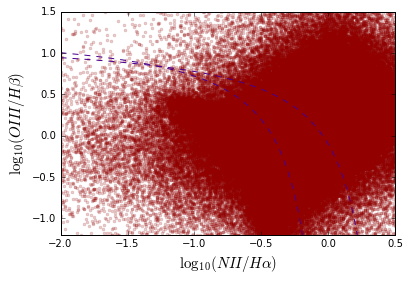

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'figure.max_open_warning': 50})

main_color = '#920000'
err_color = '#924900'
other_color = '#49008F'

# Mask para quitar ceros de los flujos.
mask = h_alpha != 0
mask *= h_beta != 0
mask *= nii_6584 != 0
mask *= oiii_5007 != 0

alpha = h_alpha[mask]
beta = h_beta[mask]
nii = nii_6584[mask]
oiii = oiii_5007[mask]

# Ahora quitamos los negativos.
nii_alpha = nii / alpha
oiii_beta = oiii / beta

mask = nii_alpha > 0
mask *= oiii_beta > 0

nii_alpha  = nii_alpha[mask]
oiii_beta = oiii_beta[mask]

# Definimos los logaritmos.
nii_alpha = np.log10(nii_alpha)
oiii_beta = np.log10(oiii_beta)

# Definimos las línas para delimintar las regiones.
def line1(x):
    return 0.61/(x-0.05)+1.3

def line2(x):
    return 0.61/(x-0.47)+1.19


def line1(x):
    return 0.61/(x-0.05)+1.3

def line2(x):
    return 0.61/(x-0.47)+1.19

plt.plot(nii_alpha, oiii_beta, '.', color=main_color, alpha=0.2)
x_line = np.sort(nii_alpha)[0: -30000]
plt.plot(x_line, line2(x_line), '--', color=other_color)
x_line = np.sort(nii_alpha)[0: -100000]
plt.plot(x_line, line1(x_line), '--', color=other_color)
plt.xlabel(r"$\log_{10}(NII/H\alpha)$", fontsize=15)
plt.ylabel(r"$\log_{10}(OIII/H\beta)$", fontsize=15)
plt.xlim(-2, 0.5)
plt.ylim(-1.2, 1.5)
plt.show()

Debido a la densidad, vamos a discriminar por señal al ruido, utilizando la misma de Kauffmann et al. ([2003](http://mnras.oxfordjournals.org/content/346/4/1055.full.pdf)): 
$\text{S/N}>3$


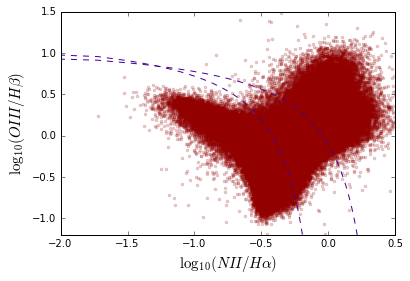

In [7]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mask = (h_alpha / h_alpha_err) > 3
    mask *= (h_beta / h_beta_err) > 3
    mask *= (nii_6584 / nii_6584_err) > 3
    mask *= (oiii_5007 / oiii_5007_err) > 3
    
    alpha = h_alpha[mask]
    beta = h_beta[mask]
    nii = nii_6584[mask]
    oiii = oiii_5007[mask]

    nii_alpha = nii / alpha
    oiii_beta = oiii / beta
    
    nii_alpha = np.log10(nii_alpha)
    oiii_beta = np.log10(oiii_beta)

plt.plot(nii_alpha, oiii_beta, '.', color=main_color, alpha=0.2)
x_line = np.sort(nii_alpha)[0: -1000]
plt.plot(x_line, line2(x_line), '--', color=other_color)
x_line = np.sort(nii_alpha)[0: -30000]
plt.plot(x_line, line1(x_line), '--', color=other_color)
plt.xlabel(r"$\log_{10}(NII/H\alpha)$", fontsize=15)
plt.ylabel(r"$\log_{10}(OIII/H\beta)$", fontsize=15)
plt.xlim(-2, 0.5)
plt.ylim(-1.2, 1.5)
plt.show()

Seleccionamos dos galaxias, siguiendo el criterio:

In [8]:
mjd_mask = mjd[mask]
plate_mask = plate[mask]
fiber_mask = fiber[mask]

with warnings.catch_warnings():
    mask1 = nii_alpha > 0.31
    mask1 *= nii_alpha < 0.32
    mask1 *= oiii_beta < 0.5
    mask1 *= oiii_beta > 0.49
    
    mask2 = nii_alpha < -0.55
    mask2 *= nii_alpha > -0.556
    mask2 *= oiii_beta > 0.11
    mask2 *= oiii_beta < 0.12


print("type\tmjd\tplate\tfiberID")
print("AGN\t{}\t{}\t{}".format(mjd_mask[mask1], plate_mask[mask1], fiber_mask[mask1]))
print("HII\t{}\t{}\t{}".format(mjd_mask[mask2], plate_mask[mask2], fiber_mask[mask2]))

type	mjd	plate	fiberID
AGN	[53474]	[2095]	[144]
HII	[53116]	[1696]	[363]


Descargamos los espectros de las galaxias de [SAS](http://mirror.sdss3.org/basicSpectra):

In [9]:
spec1 = fits.open('spec-2095-53474-0144.fits')
spec2 = fits.open('spec-1696-53116-0363.fits')



#spec2.info()
#print(spec2[3].data)
#print(len(spec2[1].data['loglam']))
#spec2[3].header
#print(spec2[2].data)

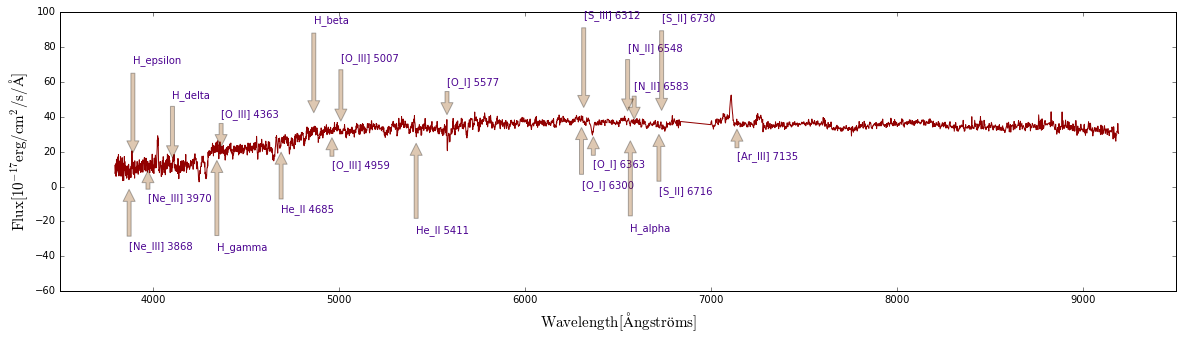

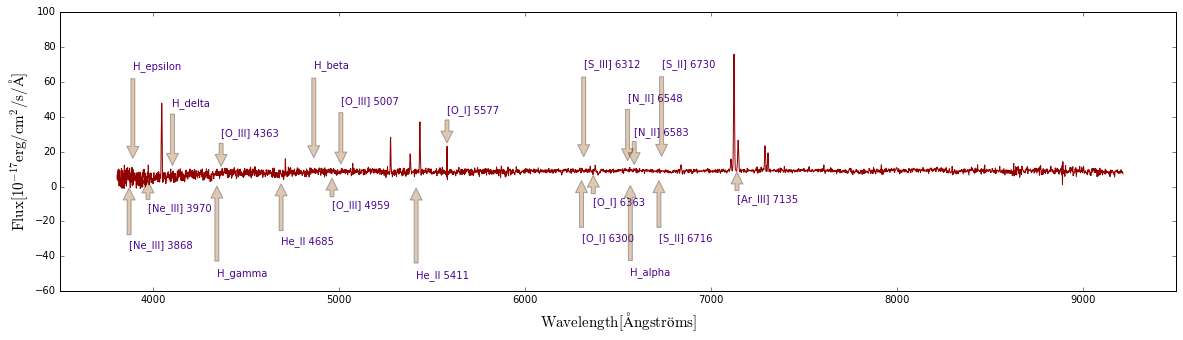

In [10]:
for x in [spec1, spec2]:
    flux = x[1].data['flux']
    wave = np.power(10, x[1].data['loglam'])
    
    lines_name = spec2[3].data['LINENAME']
    lines_wave = spec2[3].data['LINEWAVE']

    plt.figure(figsize=(20, 5))
    plt.plot(wave, flux, color=main_color)
    plt.xlim(3500, 9500)
    plt.ylim(-60, 100)
    plt.xlabel(r"$\mathrm{Wavelength [Ångströms]}$", fontsize=15)
    plt.ylabel(r"$\mathrm{Flux [10^{-17} erg/cm^2/s/\AA]}$", fontsize=15)
    
    mask = lines_wave > wave[10]
    mask *= lines_wave < wave[-100]
    lines_wave = lines_wave[mask]
    lines_name= lines_name[mask]
    
    value = 10
    for ind in range(0, len(lines_name)):
        name = lines_name[ind]
        x = lines_wave[ind]
        mask = np.ma.masked_inside(wave, x-1, x+1).mask

        y = flux[mask][0]
        if value % 6 == 0:
            value = 10
        else:
            value += 10
        plus = -value if ind % 2 == 0 else value
        plt.annotate(name, xy=(x, y+plus/5), xytext=(x, y+2*plus), color=other_color,
                     arrowprops=dict(facecolor=err_color, shrink=0.05, alpha=0.3))

Con el módulo **astroquery.sdds** vamos a descargar los _spectral templates_, que son los espectros modelos para clasificar.

In [11]:
from astropy.io import ascii
data_lines = ascii.read("lines.csv") 
data_name = data_lines['Name']
data_wave = data_lines['restWave']

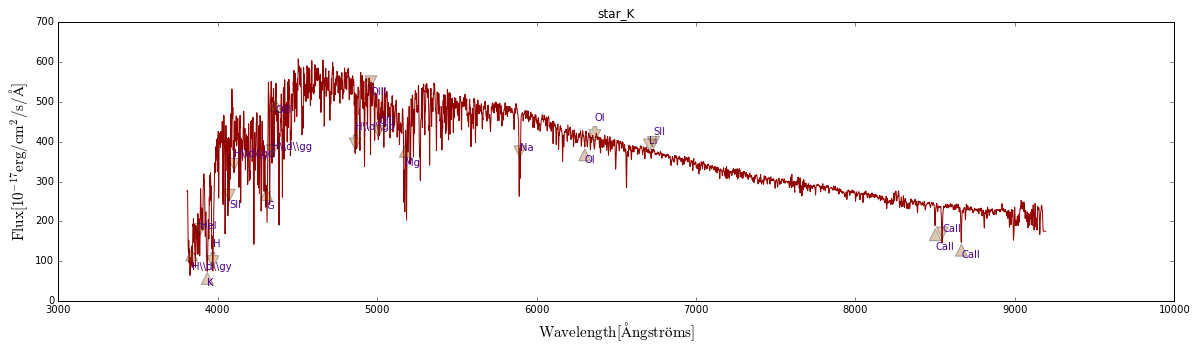

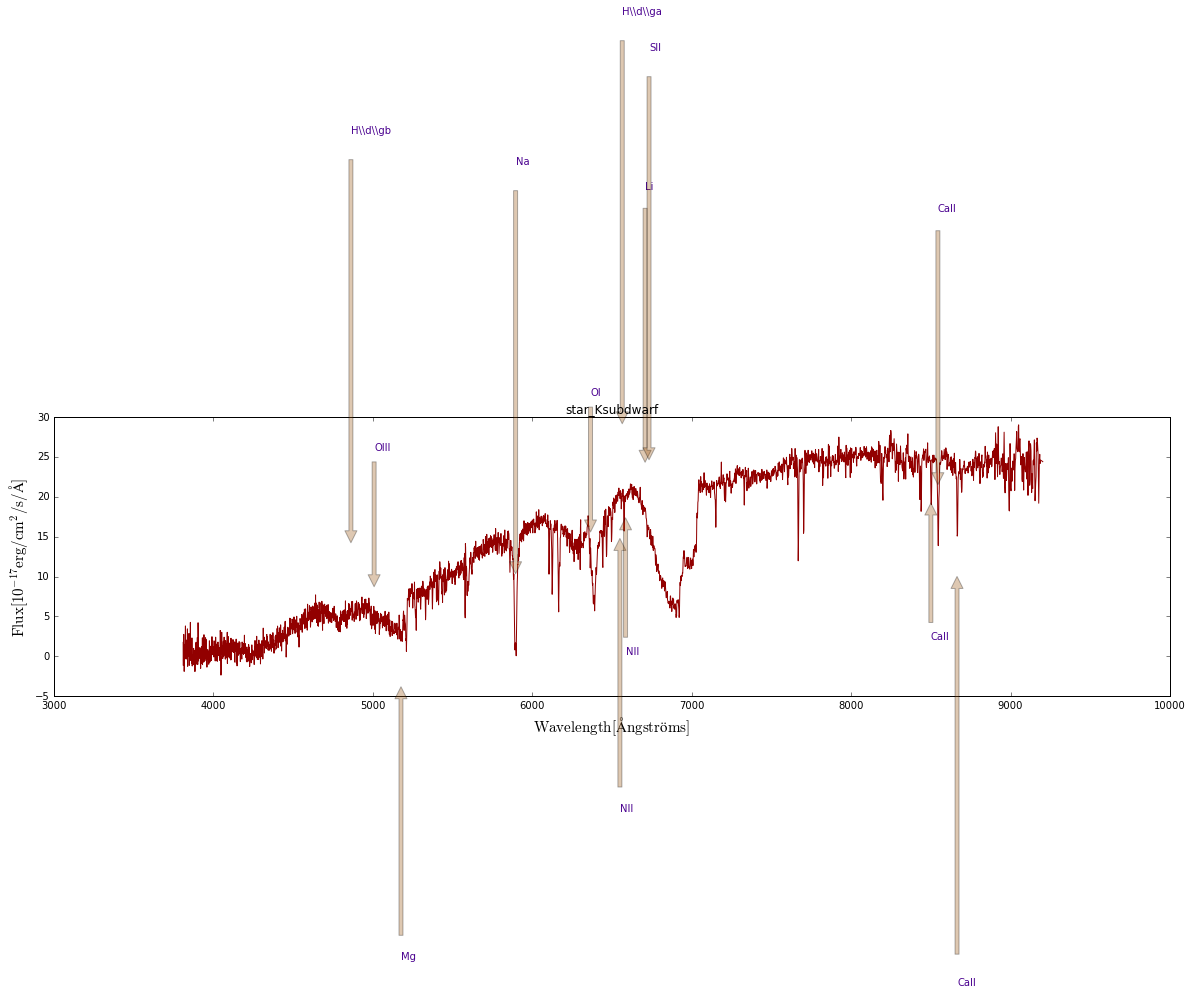

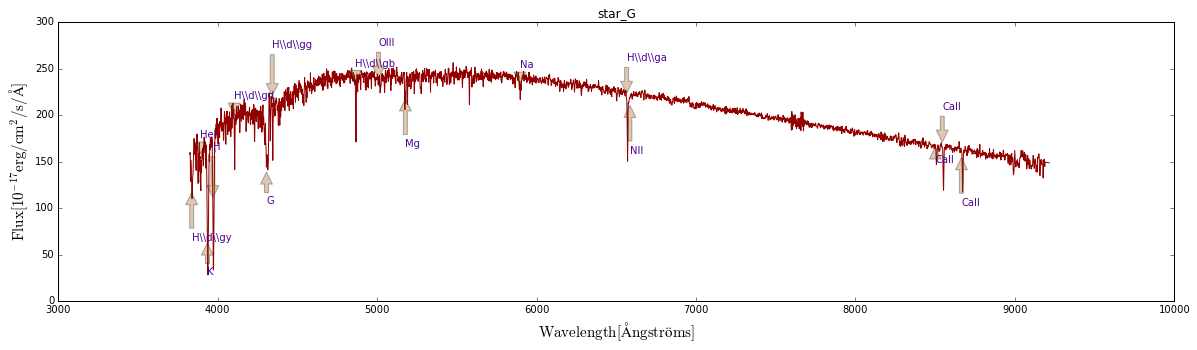

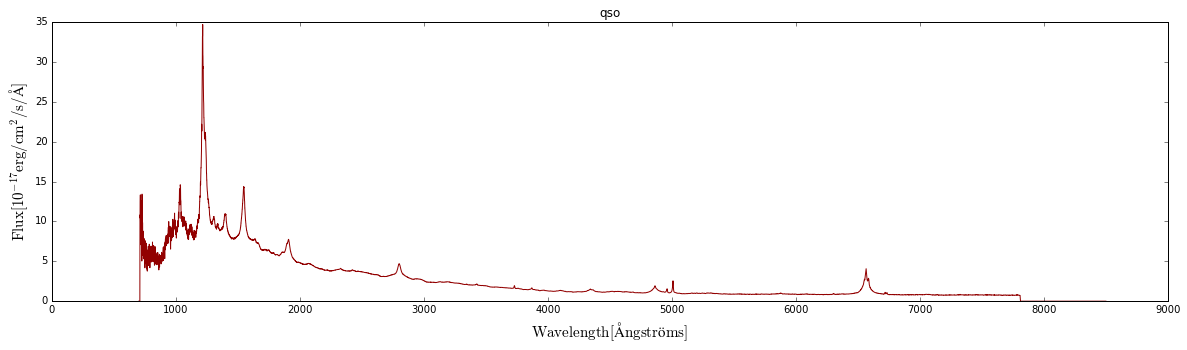

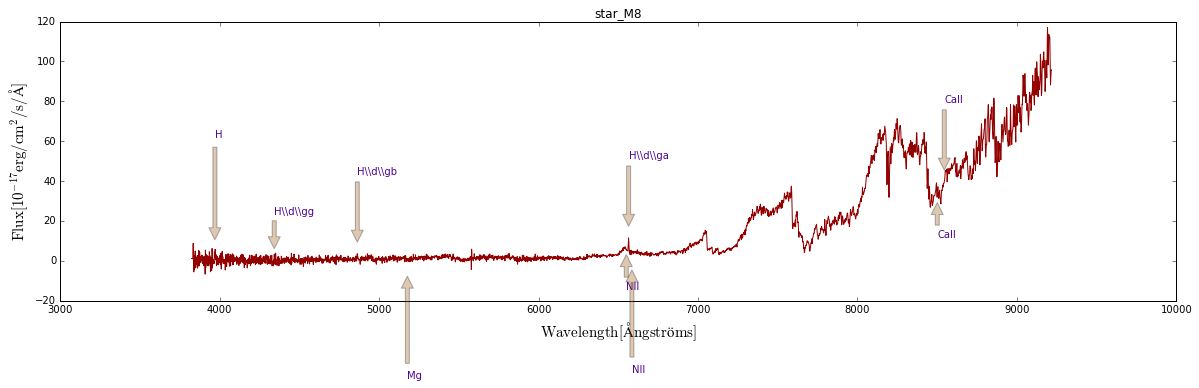

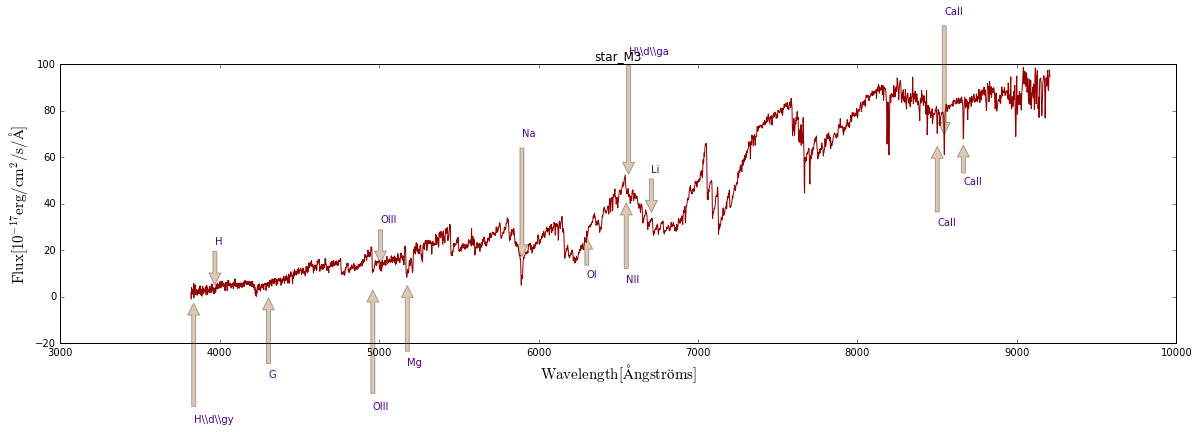

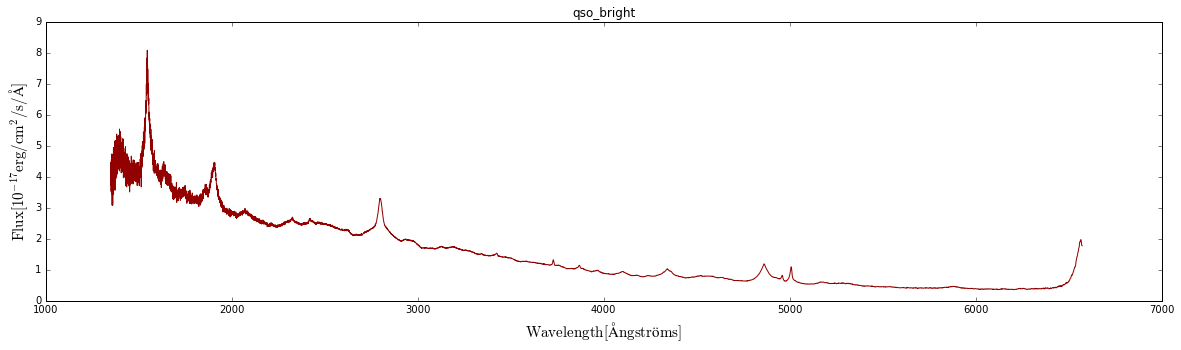

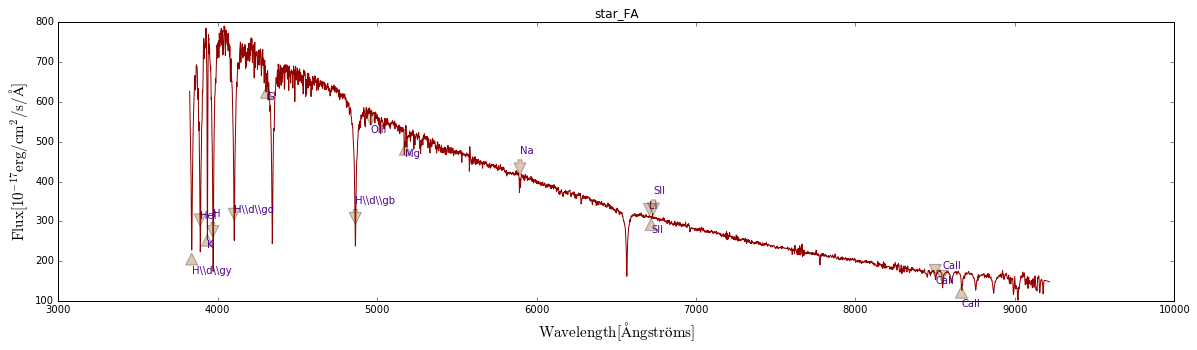

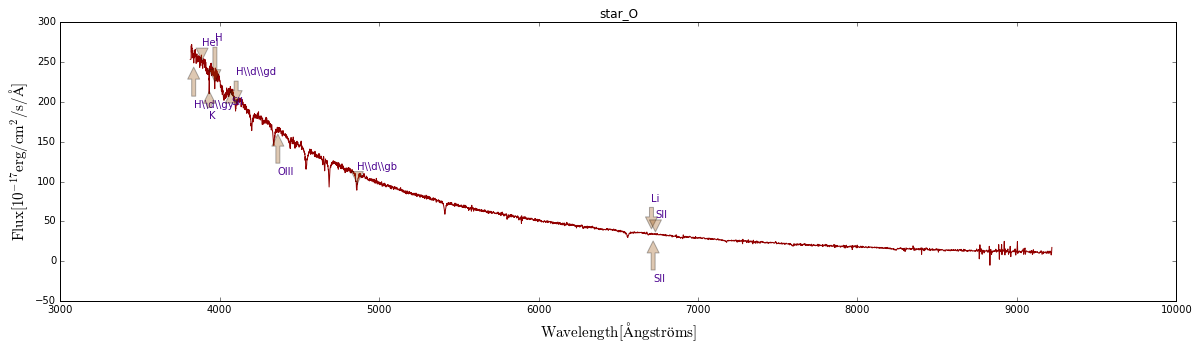

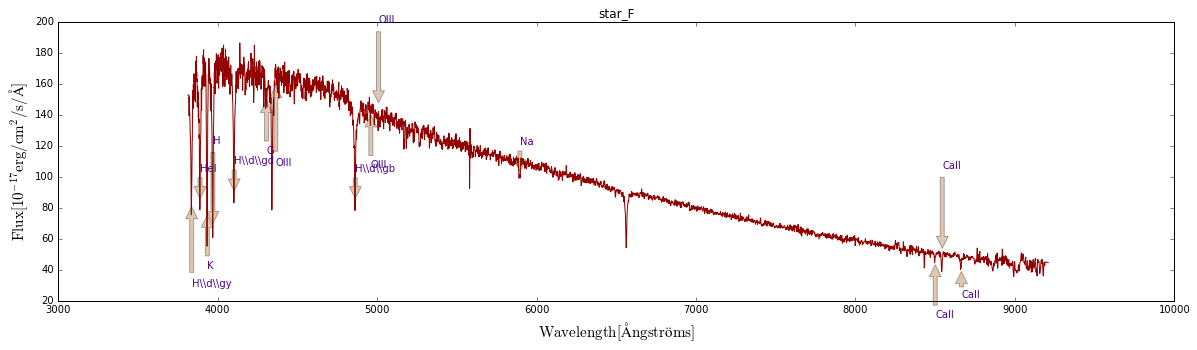

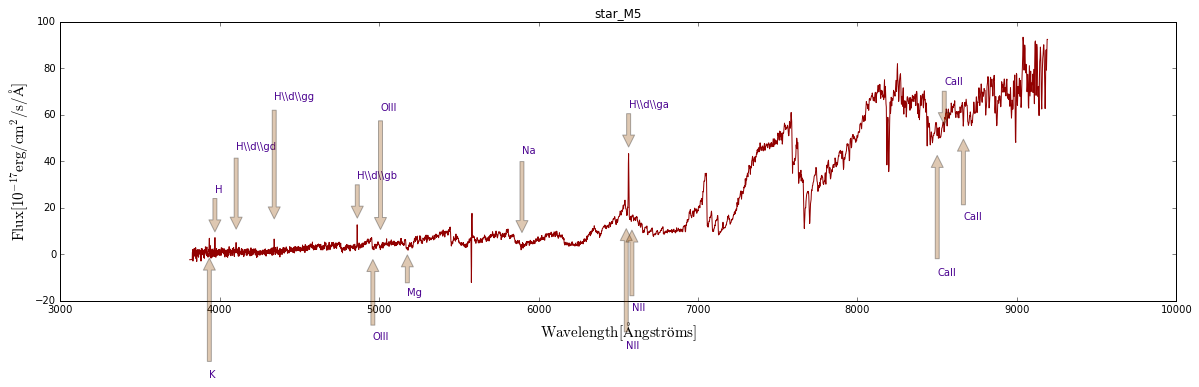

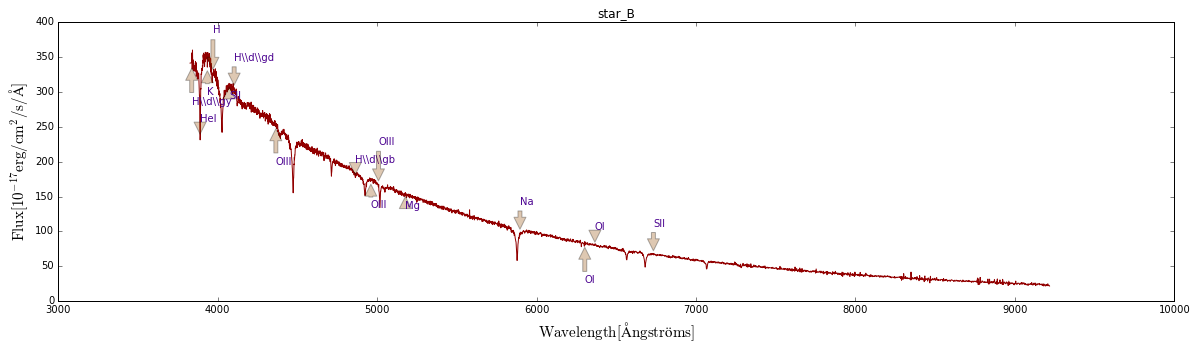

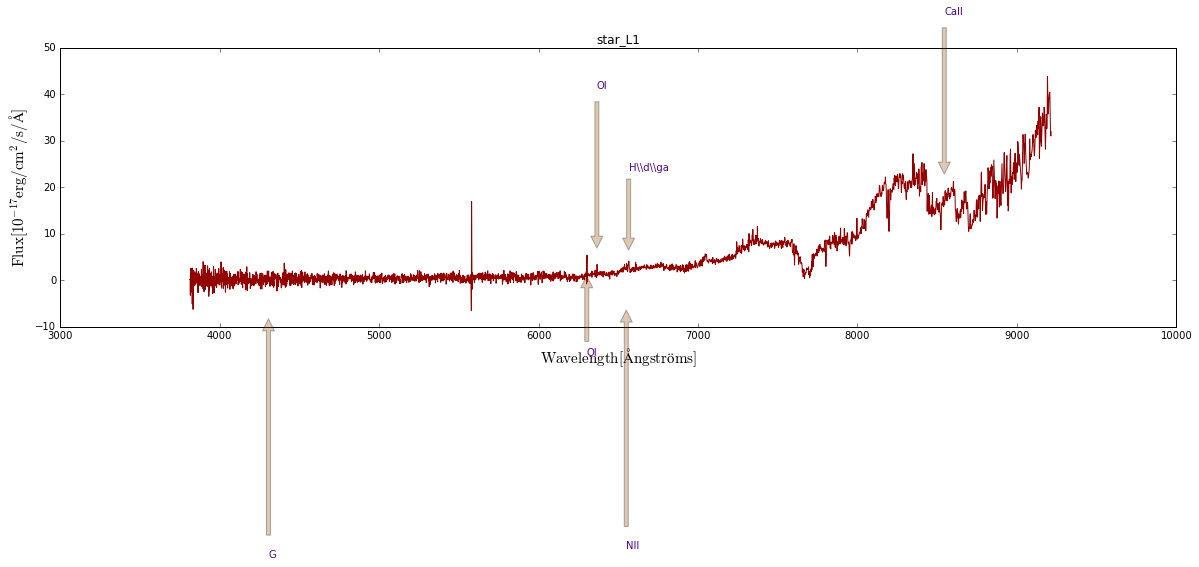

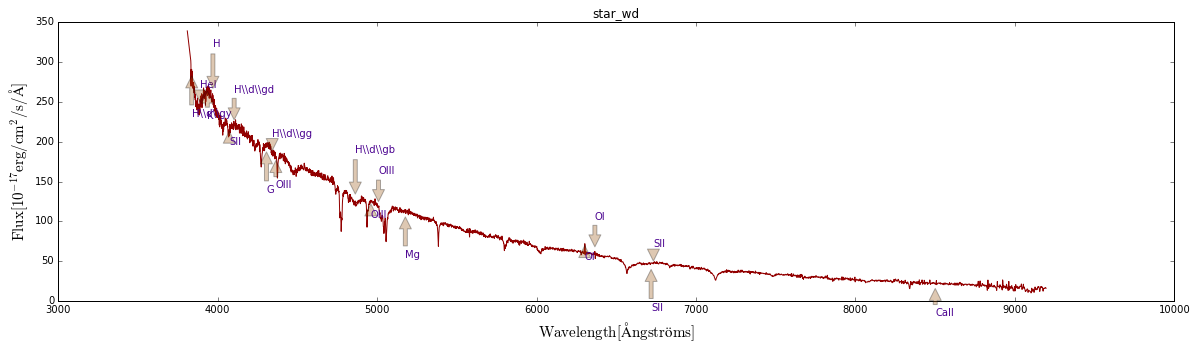

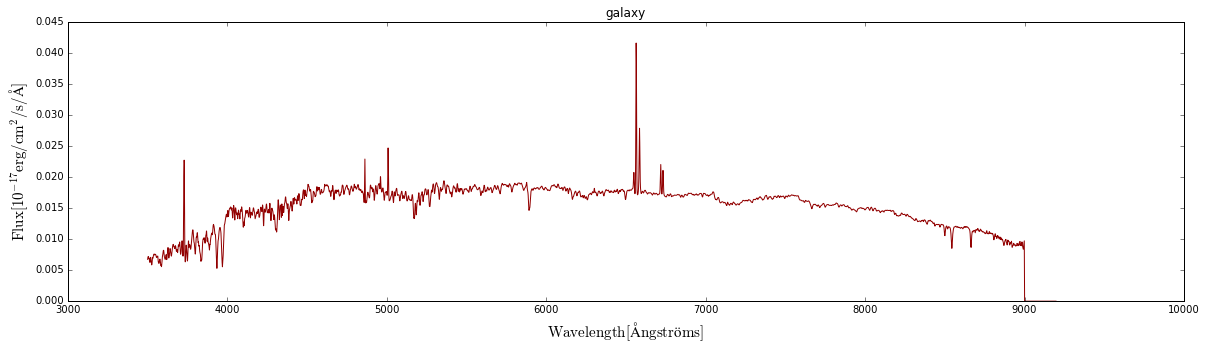

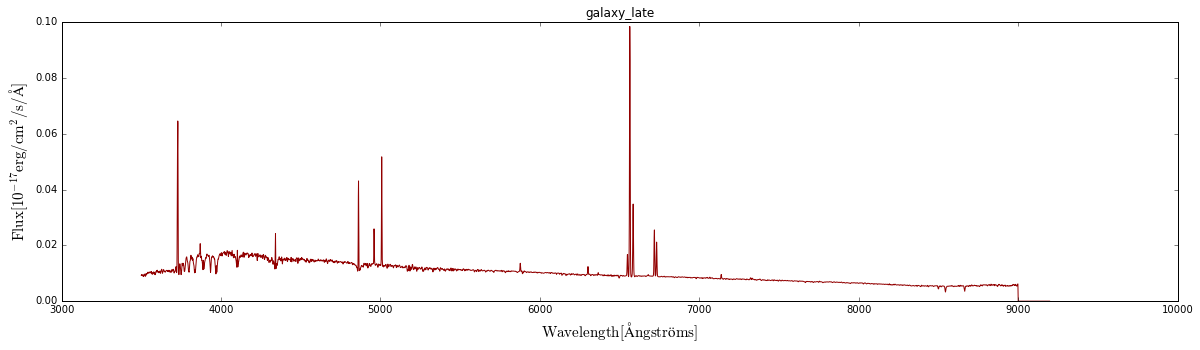

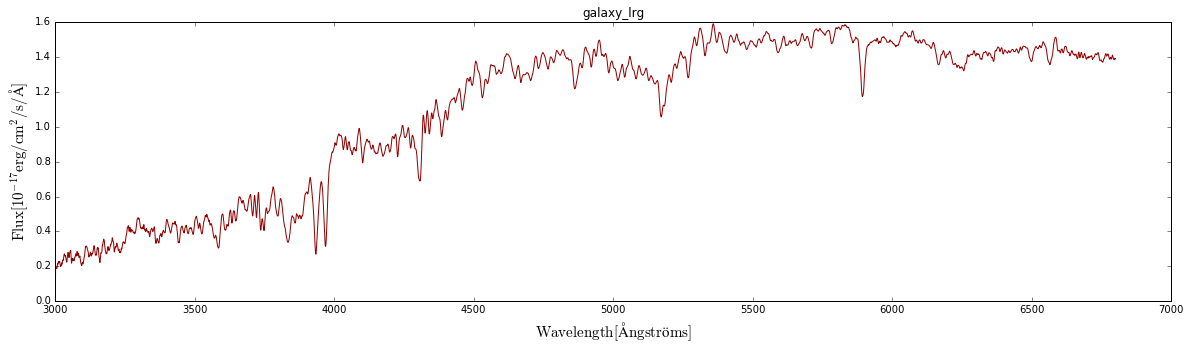

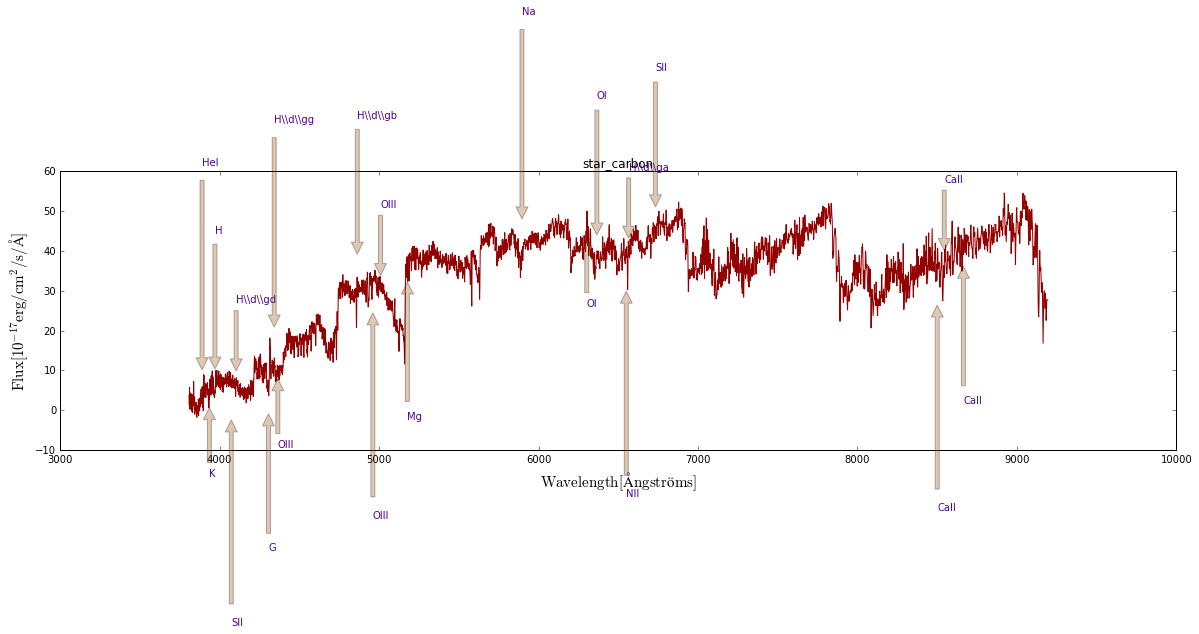

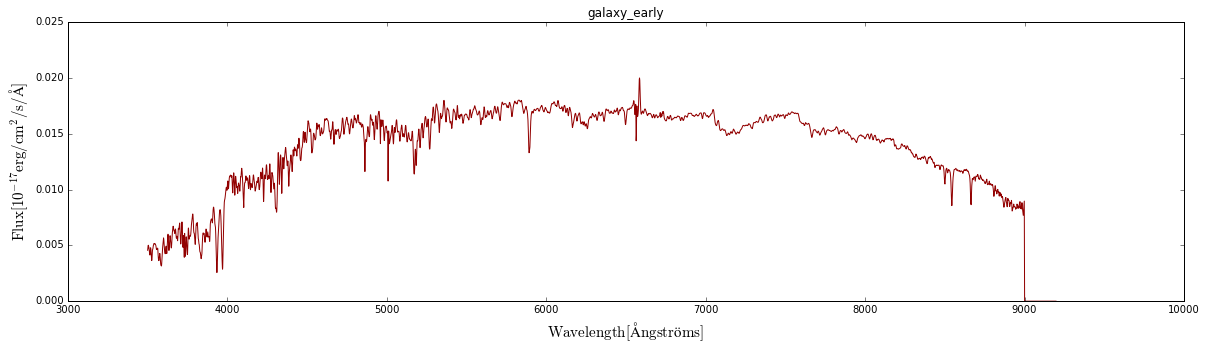

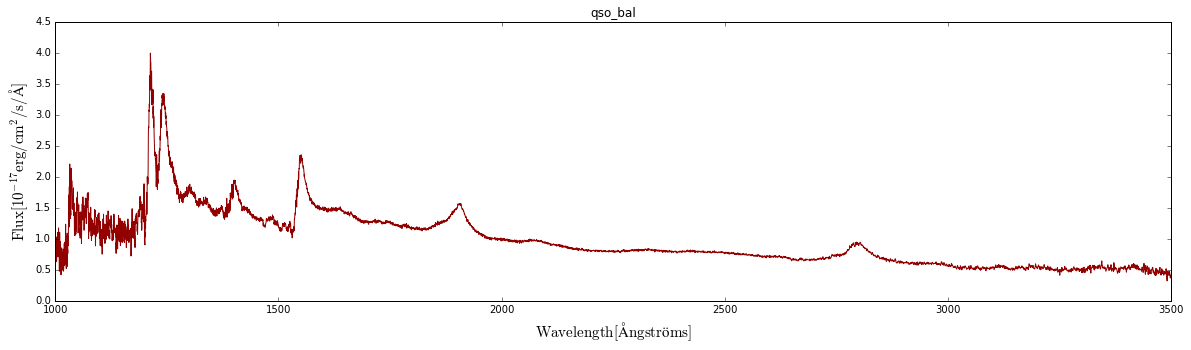

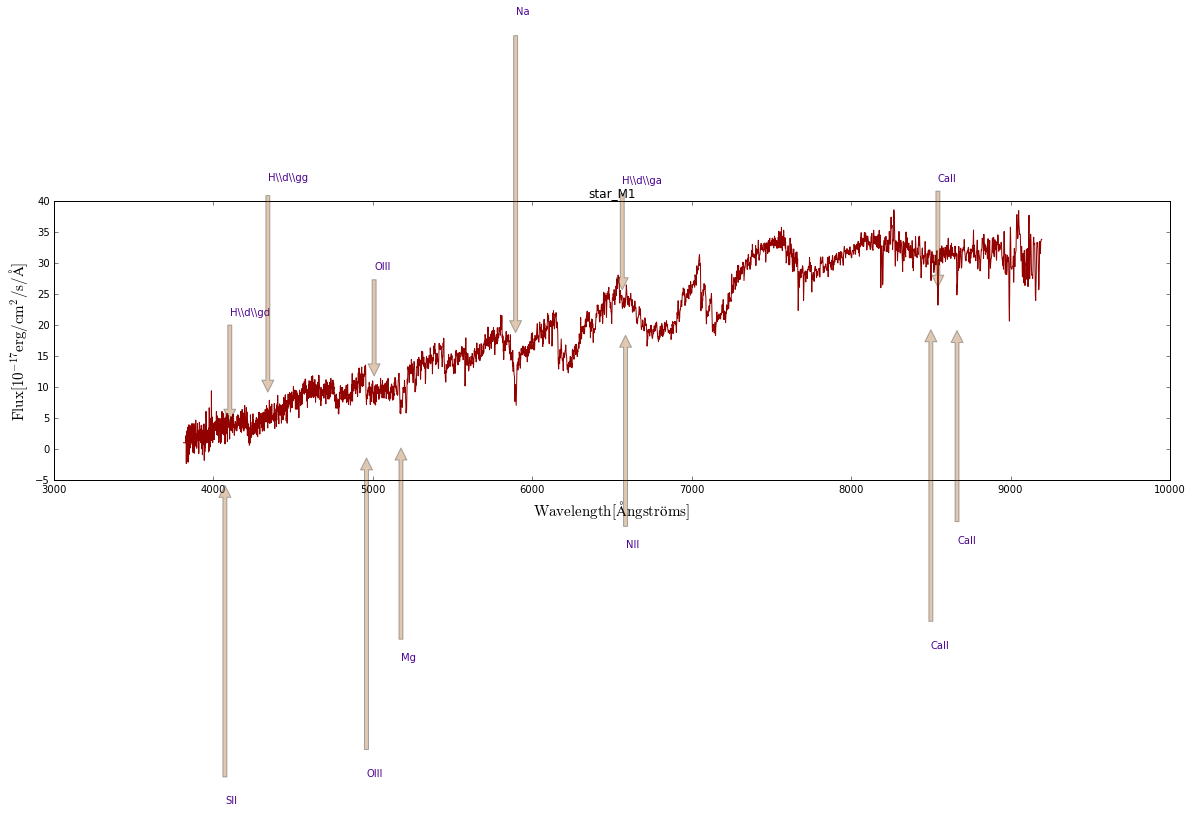

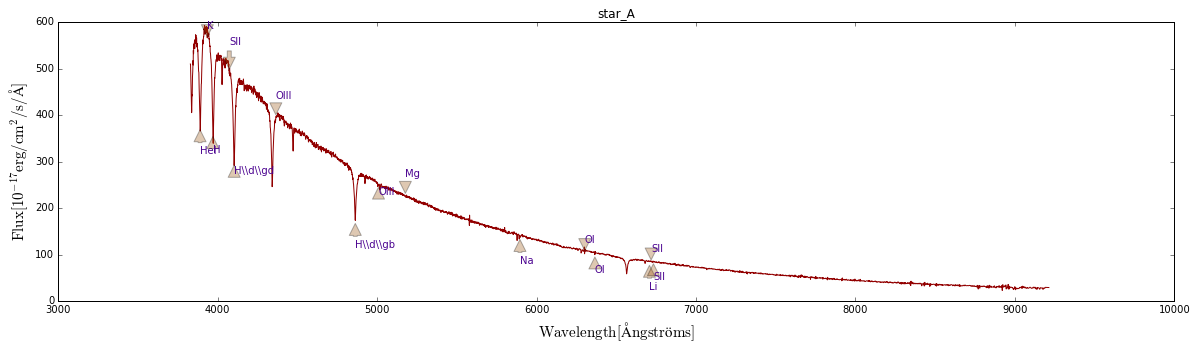

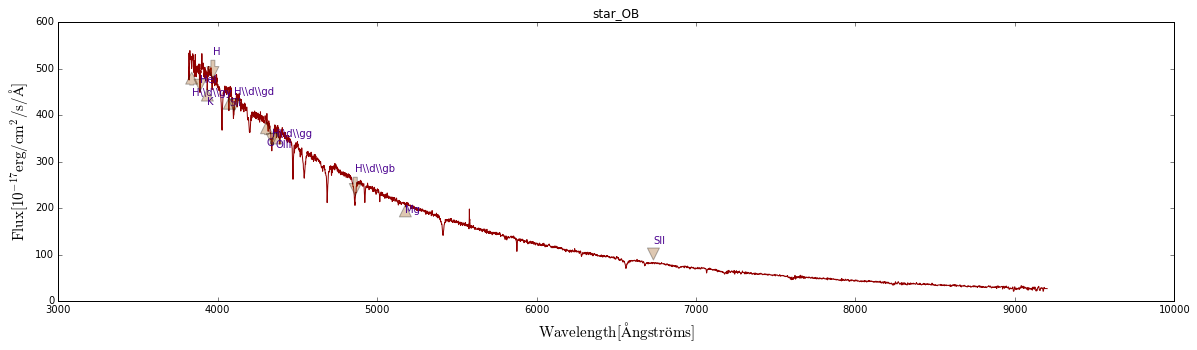

In [13]:
from astroquery.sdss import SDSS
def flux_wave(result, title):
    hdulist = result[0]
    c0 = hdulist[0].header['coeff0']
    c1 = hdulist[0].header['coeff1']
    npix = hdulist[0].header['naxis1']
    wave = 10.**(c0 + c1 * np.arange(npix))
    flux = hdulist[0].data[0,:]
    plt.figure(figsize=(20, 5))
    plt.plot(wave, flux, color=main_color)
    plt.title(title)
    #plt.xlim(3500, 9500)
    #plt.ylim(-60, 100)
    plt.xlabel(r"$\mathrm{Wavelength [Ångströms]}$", fontsize=15)
    plt.ylabel(r"$\mathrm{Flux [10^{-17} erg/cm^2/s/\AA]}$", fontsize=15)
    
    mask = data_wave > wave[10]
    mask *= data_wave < wave[-100]
    dwave = data_wave[mask]
    dname = data_name[mask]
    
    res_wave = result[0][2].data['restWave']
    res_nsigma = result[0][2].data['nsigma']
    
    if len(res_nsigma) == 0:
        return None
    
    max_flux = np.nanmax(flux)
    min_flux = np.nanmin(flux)
    
    value = 20
    for ind in range(0, len(dname)):
        name = dname[ind]
        x = dwave[ind]
        mask = np.ma.masked_inside(wave, x-1, x+1).mask
        y = flux[mask][0]
        
        mask = np.ma.masked_inside(res_wave, x-1, x+1).mask
        sigma = res_nsigma[mask]
        if sigma > 3:

            if value % 6 == 0:
                value = 10
            else:
                value += 10
            plus = -value if ind % 2 == 0 else value
            plt.annotate(name, xy=(x, y+plus/5), xytext=(x, y+2*plus), color=other_color,
                         arrowprops=dict(facecolor=err_color, shrink=0.05, alpha=0.3))

for title in SDSS.AVAILABLE_TEMPLATES:
    template = SDSS.get_spectral_template(title)
    flux_wave(template, title)